# Factor Construction

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt

from factors import calc_stock_beta, calc_fp_betas, shrink_fp_betas_cross_sectionally, process_ranked_beta_row, process_ew_beta_row, process_value_beta_row
from factors import calc_equal_weights, calc_rank_weights, calc_value_weights, plot_cml, create_ff_bab_df, create_mkt_bab_df, calc_ls_returns


In [2]:
# returns
stocks = pd.read_csv('data/stocks-2005.csv', index_col='Date', parse_dates=True,date_parser=lambda x: pd.to_datetime(x,format='%d/%m/%Y'))
mkt = pd.read_csv('data/mkt-2005.csv', index_col='Date', parse_dates=True)
ff = pd.read_csv('data/FF-2x3-5-Factor.csv', index_col='Date', parse_dates=True,  date_parser=lambda x: pd.to_datetime(x,format='%Y%m')).div(100)
ff = ff[ff.index.year >= 2005]

market_cap_df = pd.read_csv('data/market-cap-df.csv', index_col=0).sort_index()
market_cap_df.index = pd.to_datetime(market_cap_df.index, format='%Y')
stocks_m = stocks.resample('M').sum().sub(ff.RF.values,axis=0)
mkt_m = mkt.resample('M').sum().sub(ff.RF.values,axis=0)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', '#00d5ff']


In [3]:
# calculate FP betas
betas = stocks.apply(calc_fp_betas, market_returns=mkt, axis=0).dropna()
betas = betas.applymap(shrink_fp_betas_cross_sectionally)
m_betas = betas.resample('M').last()

In [4]:
# calculate rank-weights
rank_weights = calc_rank_weights(betas)
# calculate even-weights
equal_weights = calc_equal_weights(betas)
# calculate value-weighs
value_weights = calc_value_weights(betas, market_cap_df)

In [5]:
# split into LS portfolios: dollar-neutral
lrw = rank_weights.applymap(lambda x:-x if x < 0 else 0) 
srw = rank_weights.applymap(lambda x:x if x > 0 else 0) 
lew = equal_weights.applymap(lambda x:-x if x < 0 else 0) 
sew = equal_weights.applymap(lambda x:x if x > 0 else 0) 
lvw = value_weights.applymap(lambda x:-x if x < 0 else 0) 
svw = value_weights.applymap(lambda x:x if x > 0 else 0) 


# calculate portfolio betas
lr_betas = lrw.mul(m_betas).sum(axis=1)
sr_betas = srw.mul(m_betas).sum(axis=1)
le_betas = lew.mul(m_betas).sum(axis=1)
se_betas = sew.mul(m_betas).sum(axis=1)
lv_betas = lvw.mul(m_betas).sum(axis=1)
sv_betas = svw.mul(m_betas).sum(axis=1)


# calculate leveraged weights: beta neutral but no longer dollar-neutral
llrw = lrw.div(lr_betas,axis=0)
lsrw = srw.div(sr_betas,axis=0)
llew = lew.div(le_betas,axis=0)
lsew = sew.div(se_betas,axis=0)
llvw = lew.div(le_betas,axis=0)
lsvw = sew.div(se_betas,axis=0)

# factor returns
_lrr, _srr, _rr = calc_ls_returns(lrw, srw, stocks_m)
_ler, _ser, _er = calc_ls_returns(lew, sew, stocks_m)
_lvr, _svr, _vr = calc_ls_returns(lvw, svw, stocks_m)

lrr, srr, rr = calc_ls_returns(llrw, lsrw, stocks_m)
ler, ser, er = calc_ls_returns(llew, lsew, stocks_m)
lvr, svr, vr = calc_ls_returns(llvw, lsvw, stocks_m)

# Flat Capital Market Line

* Entire time
* Analysis 

In [6]:
capm_betas = stocks_m.apply(calc_stock_beta, market_returns=mkt_m)
mean_rets = stocks_m.mean().mul(100)
capm_df = pd.DataFrame({'returns':mean_rets, 'betas':capm_betas})

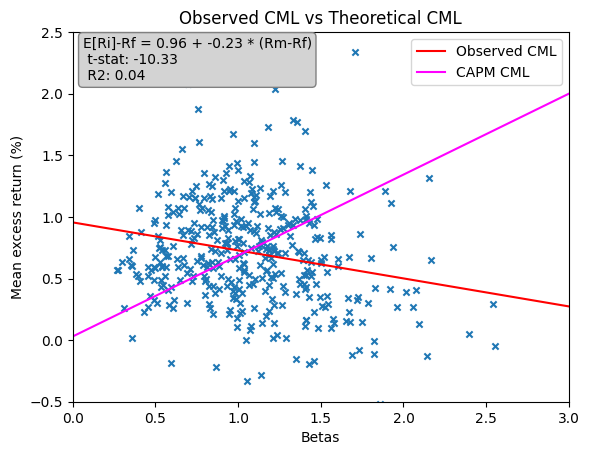

In [7]:
plot_cml(capm_df)

# Betas of LS Portfolio

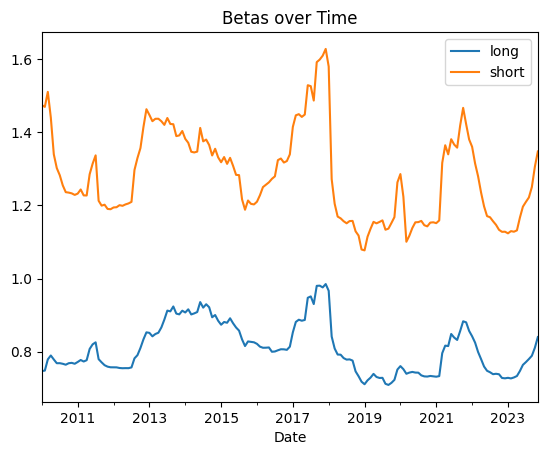

In [8]:
ls_betas = pd.DataFrame({'long':lr_betas, 'short':sr_betas})
ls_betas.plot(title='Betas over Time')
plt.show()


# BAB against Fama-French 5 Factor Model

* Regression equation
* Correlation matrix
* Line plot
* Analysis

In [9]:
bab = pd.read_csv('data/aqr-bab.csv', index_col='Date', parse_dates=True)
rw_bab_ff = create_ff_bab_df(bab,ff)

In [10]:
Y = rw_bab_ff['BAB']
X = rw_bab_ff[['Mkt-RF','SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.params

const     0.005686
Mkt-RF   -0.018108
SMB      -0.024970
HML      -0.061757
RMW       0.110760
CMA       0.194415
dtype: float64

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BAB   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.263
Date:                Sat, 10 Feb 2024   Prob (F-statistic):              0.282
Time:                        12:29:24   Log-Likelihood:                 391.27
No. Observations:                 167   AIC:                            -770.5
Df Residuals:                     161   BIC:                            -751.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.002      2.955      0.004       0.002       0.009
Mkt-RF        -0.0181      0.045     -0.400      0.689      -0.107       0.071
SMB           -0.0250      0.088     -0.284      0.776      -0.198       0.148
HML           -0.0618      0.079     -0.785      0.434      -0.217       0.094
RMW            0.1108      0.104      1.061      0.290      -0.095       0.317
CMA            0.1944      0.118      1.649      0.101      -0.038       0.427
==============================================================================
Omnibus:                       26.827   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.262
Skew:                          -0.297   Prob(JB):                     1.74e-32
Kurtosis:                       7.546   Cond. No.                         72.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
rw_bab_ff

,Mkt-RF,SMB,HML,RMW,CMA,BAB
Date,,,,,,
2010-01-01,-0.0336,0.0034,0.0043,-0.0127,0.0046,0.0100
2010-02-01,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0077
2010-03-01,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0154
2010-04-01,0.0200,0.0498,0.0289,0.0069,0.0172,0.0150
2010-05-01,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0055
...,...,...,...,...,...,...
2023-07-01,0.0321,0.0286,0.0411,-0.0057,0.0057,-0.0086
2023-08-01,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0153
2023-09-01,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0105


In [13]:
rw_bab_ff.corr()

,Mkt-RF,SMB,HML,RMW,CMA,BAB
Mkt-RF,1.000000,0.363511,0.076120,-0.085461,-0.129466,-0.080648
SMB,0.363511,1.000000,0.273320,-0.401029,0.031852,-0.094347
HML,0.076120,0.273320,1.000000,0.074750,0.646420,0.023437
RMW,-0.085461,-0.401029,0.074750,1.000000,0.132113,0.122278
CMA,-0.129466,0.031852,0.646420,0.132113,1.000000,0.133792
BAB,-0.080648,-0.094347,0.023437,0.122278,0.133792,1.000000


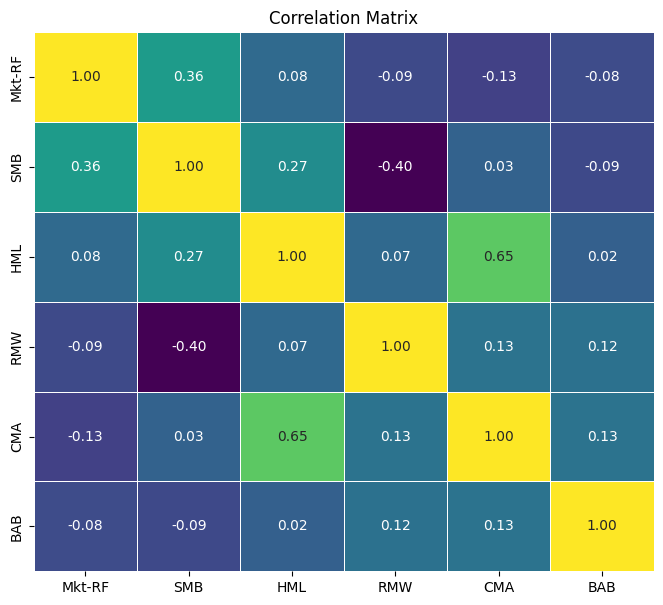

In [44]:
plt.figure(figsize=(8, 7))  # Set the figure size as per your preference
sns.heatmap(rw_bab_ff.corr(), cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar=False)
plt.title("Correlation Matrix")
plt.show()

<AxesSubplot: title={'center': 'BAB vs FF5'}, xlabel='Date'>

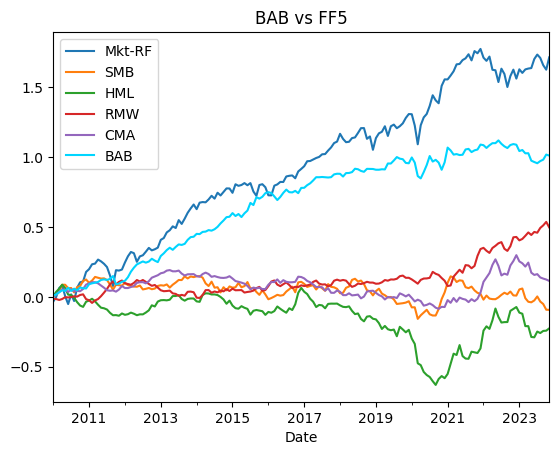

In [14]:
rw_bab_ff.cumsum().plot(title='BAB vs FF5', color=colors)
# plt.ylabel('returns')

<AxesSubplot: title={'center': 'Sharpe ratios: BAB vs FF5'}>

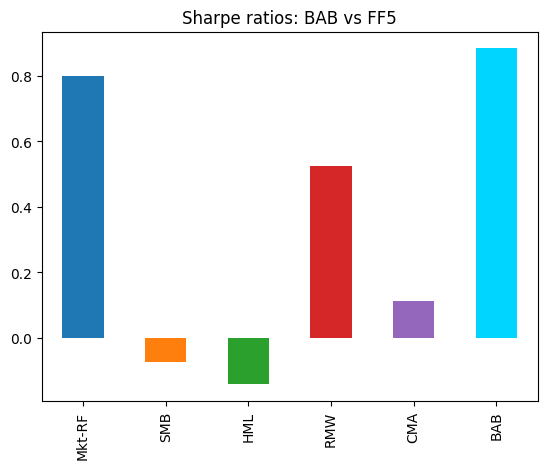

In [15]:
rw_bab_ff.mean().div(rw_bab_ff.std()).mul(np.sqrt(12)).plot(kind='bar', color=colors, title='Sharpe ratios: BAB vs FF5')

<AxesSubplot: title={'center': 'BAB Tilts'}>

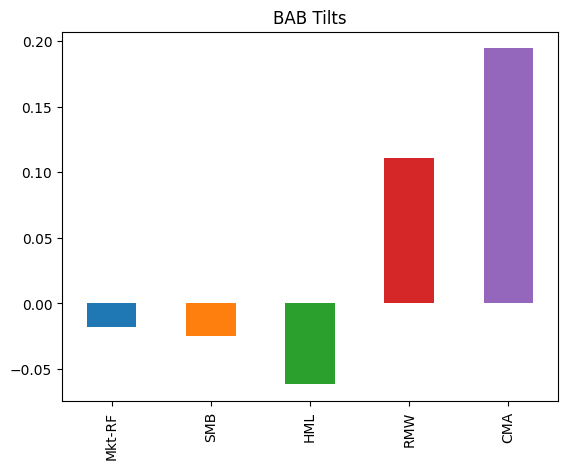

In [16]:
results.params[1:].plot(kind='bar',color=colors, title='BAB Tilts')

# BAB against Market Factor

* Regression Equation
* Line plot
* Analysis

In [17]:

bab_mkt = create_mkt_bab_df(bab, ff['Mkt-RF'])
bab_mkt.corr()

,BAB,MKT
BAB,1.000000,-0.080648
MKT,-0.080648,1.000000


<AxesSubplot: xlabel='MKT', ylabel='BAB'>

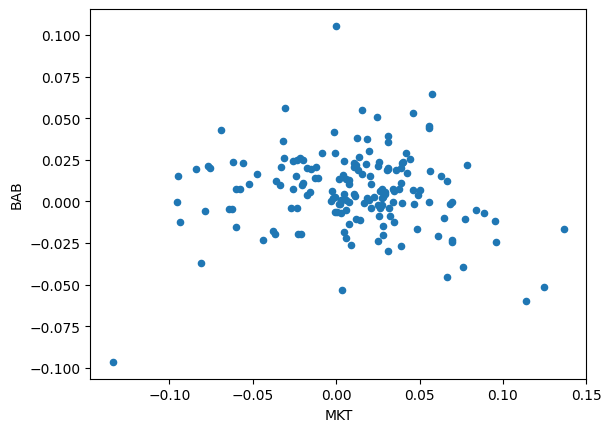

In [18]:
bab_mkt.plot(kind='scatter', x='MKT',y='BAB')

<AxesSubplot: xlabel='Date'>

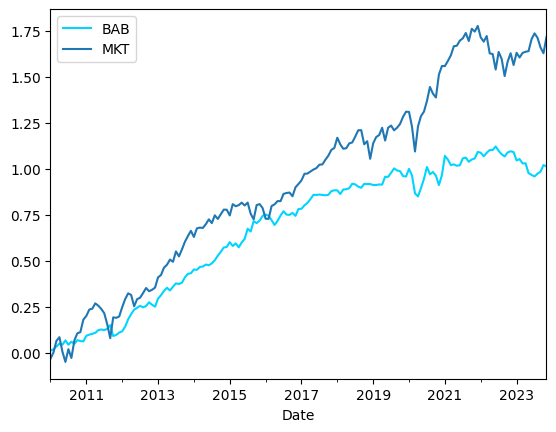

In [19]:
bab_mkt.cumsum().plot(color=['#00d5ff','tab:blue'])

In [20]:
Y = bab_mkt['BAB']
X = bab_mkt['MKT']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BAB   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.080
Date:                Sat, 10 Feb 2024   Prob (F-statistic):              0.300
Time:                        12:29:25   Log-Likelihood:                 388.60
No. Observations:                 167   AIC:                            -773.2
Df Residuals:                     165   BIC:                            -767.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.002      3.446      0.001       0.003       0.010
MKT           -0.0431      0.041     -1.039      0.300      -0.125       0.039
==============================================================================
Omnibus:                       21.679   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.941
Skew:                          -0.211   Prob(JB):                     1.47e-21
Kurtosis:                       6.689   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'BAB')

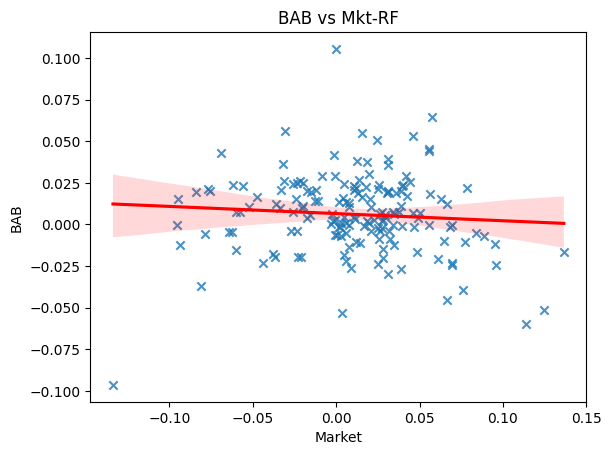

In [21]:
sns.regplot(x='MKT', y='BAB', data=bab_mkt, marker='x', line_kws={"color": "red"})

# Add title and labels
plt.title('BAB vs Mkt-RF')
plt.xlabel('Market')
plt.ylabel('BAB')

# BAB: Value Weighted vs Ranked vs Equal Weighted (BABAB)

* Lineplot
* Analysis

<AxesSubplot: title={'center': 'Custom BAB'}, xlabel='Date'>

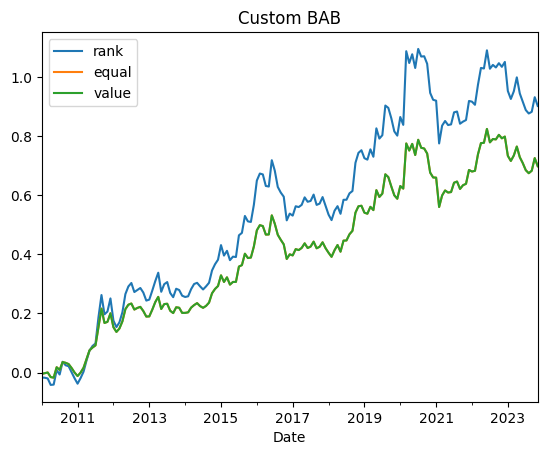

In [22]:
rev_perf = pd.DataFrame({"rank":rr,"equal":er,"value":vr})
rev_perf.cumsum().plot(title='Custom BAB')

# BAB Overweighting Small Cap Stocks (BABAB)

* Turnover by size decile barchart
    * For each time period row, have a dataframe of two columns: decile bucket and turnover
    * Groupby decile and sum
    * Do this for all rows 
    * Plot barchart
* Correlation to size factor scatterplot
* Lineplot with transaction costs
    * Figure out a way to proxy measure transaction costs as a function of market cap

In [23]:
mkt_cap_df = market_cap_df.resample('Y').last()[(market_cap_df.index.year <= 2023)&(market_cap_df.index.year >= 2010)]

def calculate_decile_ranks(column):
    return pd.qcut(column, q=10, labels=False) + 1

# Apply the function to each column (axis=0) and store the result
mkt_cap_df = mkt_cap_df.apply(calculate_decile_ranks, axis=1)

l_turnover = llrw.diff().dropna().abs()
l_turnover = l_turnover.resample('Y').sum()
s_turnover = lsrw.diff().dropna().abs()
s_turnover = s_turnover.resample('Y').sum()

In [24]:
def calc_turnover(mkt_cap_df, turnover_df):

    dfs = []
    for idx, row in turnover_df.iterrows():
        cap_row = mkt_cap_df.loc[idx]
        df = pd.DataFrame({'cap':cap_row,'turnover':row})
        df = pd.DataFrame(df.groupby(cap_row).turnover.sum())
        dfs.append(df)

    dfs = pd.concat(dfs)
    dfs.groupby(dfs.index).sum()
    return dfs.groupby(dfs.index).sum()

In [25]:
l_turnovers = calc_turnover(mkt_cap_df, l_turnover)
s_turnovers = calc_turnover(mkt_cap_df, s_turnover)

In [26]:
turnovers = pd.DataFrame({'long_turnover':l_turnovers.values.flatten(),'short_turnover':s_turnovers.values.flatten()}, index=l_turnovers.index)

<AxesSubplot: title={'center': 'Turnover by Market Cap Decile'}>

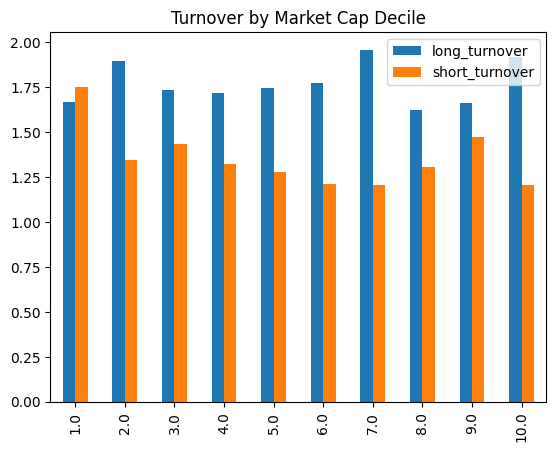

In [27]:
turnovers.plot(kind='bar', title='Turnover by Market Cap Decile')

<AxesSubplot: title={'center': 'Market Cap Decile Breakpoints 2023: BN $USD'}>

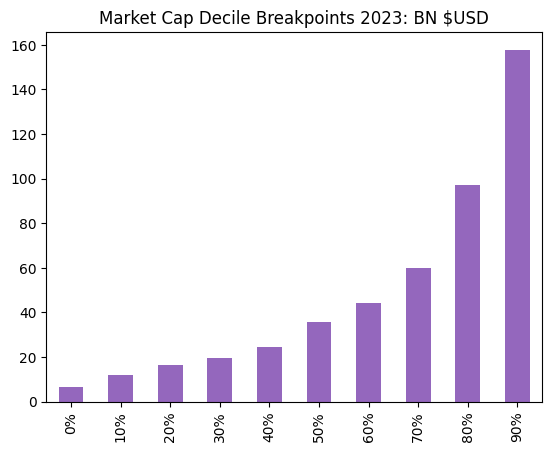

In [28]:
market_cap_df.iloc[-2].T.div(1000).describe(percentiles=np.arange(0,1,0.1))[4:-1].plot(kind='bar', color='tab:purple', title='Market Cap Decile Breakpoints 2023: BN $USD')

# BAB Seasonality

* Sharpe by month
* Drawdown by month

Text(0.5, 0, 'M')

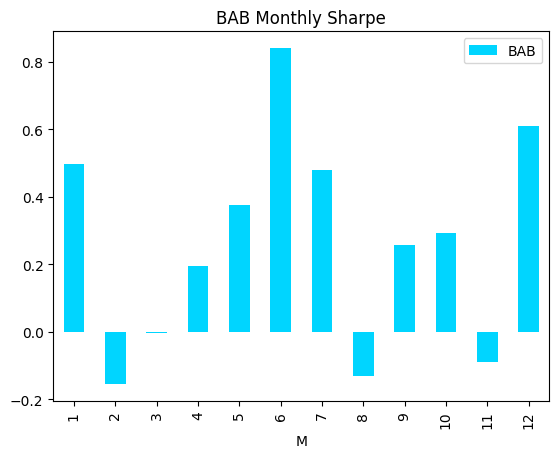

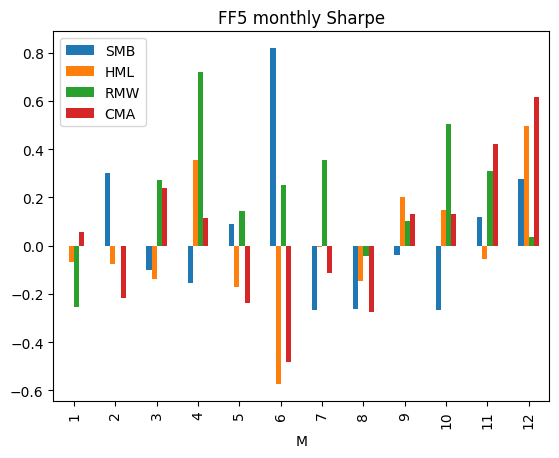

In [29]:
bab.groupby(bab.index.month).apply(lambda x: x.mean()/x.std()).plot(kind='bar', color='#00d5ff', title='BAB Monthly Sharpe')
plt.xlabel('M')

ff.iloc[:,1:-1].groupby(ff.index.month).apply(lambda x: x.mean()/x.std()).plot(kind='bar', title='FF5 monthly Sharpe')
plt.xlabel('M')

# BAB Performance and Funding Liquidity Risk (TED spread)

* Lineplot
* Scatterplot
* Regression

In [30]:
ted = pd.read_csv('data/ted-spread.csv',index_col='date', parse_dates=True, date_parser=lambda x: pd.to_datetime(x,format='%d/%m/%Y'))
ted = ted.resample('M').last()
bab = bab.loc[ted.index[ted.index.isin(bab.index)]]

In [31]:
ted_bab = pd.DataFrame({'ted':ted.values.flatten(),'bab':bab.values.flatten()},index=bab.index)

ted_bab['ted'] = ted_bab.ted.shift(-1).dropna()
ted_bab['log_ted']= np.log2(ted_bab.ted)
ted_bab = ted_bab.dropna()

Text(0.5, 0, 'TED')

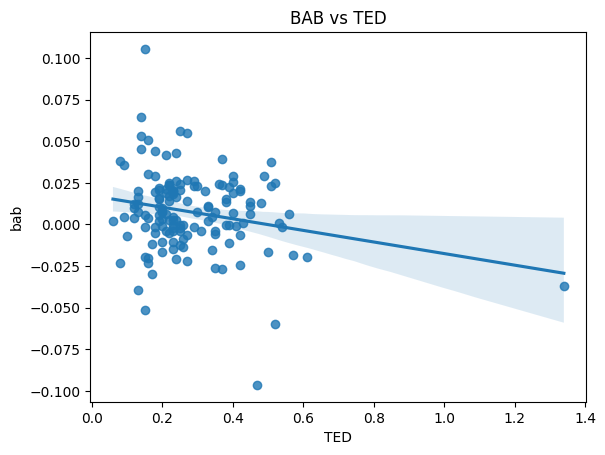

In [32]:
sns.regplot(x='ted', y='bab', data=ted_bab)

# Add title and labels
plt.title('BAB vs TED')
plt.xlabel('TED')
# plt.ylabel('BAB')

Text(0.5, 0, 'TED')

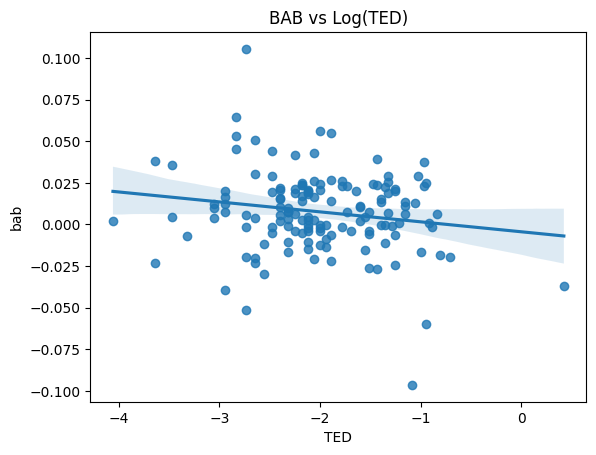

In [33]:
sns.regplot(x='log_ted', y='bab', data=ted_bab)

# Add title and labels
plt.title('BAB vs Log(TED)')
plt.xlabel('TED')
# plt.ylabel('BAB')

In [34]:
Y = ted_bab['bab']
X = ted_bab['ted']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bab   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.155
Date:                Sat, 10 Feb 2024   Prob (F-statistic):            0.00835
Time:                        12:29:28   Log-Likelihood:                 337.83
No. Observations:                 144   AIC:                            -671.7
Df Residuals:                     142   BIC:                            -665.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173      0.004      4.197      0.000       0.009       0.025
ted           -0.0348      0.013     -2.675      0.008      -0.060      -0.009
==============================================================================
Omnibus:                       16.322   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.294
Skew:                          -0.169   Prob(JB):                     3.62e-13
Kurtosis:                       6.072   Cond. No.                         7.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
ted_bab.corr()

,ted,bab,log_ted
ted,1.000000,-0.219018,0.915486
bab,-0.219018,1.000000,-0.173970
log_ted,0.915486,-0.173970,1.000000


# Post Cover

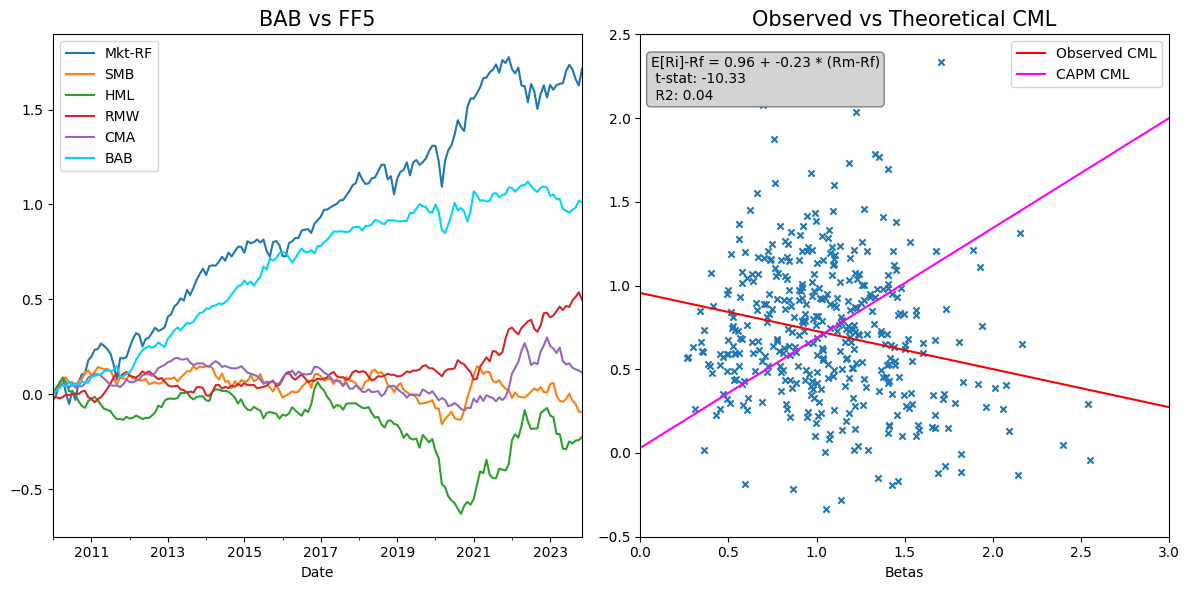

In [36]:

def plot_cml(df, ax):
    # Scatterplot with regression line on ax[1]
    df.plot(kind='scatter', x='betas', y='returns', xlim=[0, 3], ylim=[-0.5, 2.5], marker='x', ax=ax)

    # Fit a linear regression model
    X = df['betas'].values.reshape(-1, 1)
    y = df['returns'].values
    model = LinearRegression().fit(X, y)
    beta_coef = model.coef_[0]
    beta_std_error = stats.sem(y - model.predict(X))
    t_statistic = beta_coef / beta_std_error
    r_squared = model.score(X, y)

    # Plot the observed CML line on ax[1]
    ax.plot([0, 3], [model.intercept_, model.intercept_ + 3 * model.coef_[0]], label='Observed CML', color='red')

    # Plot the CAPM CML line (slope 1) on ax[1]
    ax.plot([0, 3], [0.03, 2], label='CAPM CML', color='magenta')

    # Display the regression equation on the plot on ax[1]
    ax.annotate(f'E[Ri]-Rf = {model.intercept_:.2f} + {model.coef_[0]:.2f} * (Rm-Rf)\n t-stat: {t_statistic:.2f}\n R2: {r_squared:.2f}', fontsize=10, xy=(0.02, 0.87), xycoords='axes fraction', bbox=dict(facecolor='lightgrey', edgecolor='grey', boxstyle='round'), color='black')

    # Set labels and legend on ax[1]
    ax.set_xlabel('Betas')
    ax.set_ylabel('')
    ax.legend()
    ax.set_title('Observed vs Theoretical CML', size=15)

fig, ax = plt.subplots(1,2, figsize=(12,6))
rw_bab_ff.cumsum().plot( color=colors, ax=ax[0])
ax[0].set_title('BAB vs FF5', size=15)
plot_cml(capm_df,ax=ax[1])
plt.tight_layout()

plt.savefig(fr'C:\Users\Ryan\Desktop\website\analytic-musings.com\assets\images\BAB\0.png')